In [2]:
# Import 
import os
import time
import json
import datetime
import pandas as pd

from pathlib import Path


from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory

from tyssue.solvers.quasistatic import QSSolver
from tyssue.solvers.viscous import EulerSolver

from polarity.dynamics import RadialTension

import matplotlib.pyplot as plt
%matplotlib inline

"""
from tyssue import Sheet
from tyssue.draw import sheet_view
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors

from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import actions, basic_events
from tyssue.solvers.viscous import EulerSolver

from tyssue.topology import type1_transition, remove_face

from tyssue.utils import data_at_opposite
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif
from tyssue.solvers.quasistatic import QSSolver

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units
from tyssue.utils import to_nd
"""

'\nfrom tyssue import Sheet\nfrom tyssue.draw import sheet_view\nfrom tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom\nfrom tyssue.io import hdf5\nfrom tyssue.dynamics import model_factory, effectors\n\nfrom tyssue.behaviors import EventManager\nfrom tyssue.behaviors.sheet import actions, basic_events\nfrom tyssue.solvers.viscous import EulerSolver\n\nfrom tyssue.topology import type1_transition, remove_face\n\nfrom tyssue.utils import data_at_opposite\nfrom tyssue.utils.decorators import face_lookup\n\n\nfrom tyssue.draw import highlight_faces, create_gif\nfrom tyssue.solvers.quasistatic import QSSolver\n\nfrom tyssue.dynamics.sheet_gradients import height_grad\nfrom tyssue.dynamics import units\nfrom tyssue.utils import to_nd\n'

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticityTest'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
smodel = model_factory([
    RadialTension,
    effectors.LumenVolumeElasticity,
    effectors.FaceAreaElasticity,
    effectors.FaceContractility],
effectors.FaceAreaElasticity)


model = smodel

# Initialisation of the tissue

In [9]:
def init():
    dsets = hdf5.load_datasets('../examples/superegg_final.hf5',
                               data_names=['vert', 'edge', 'face'])

    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)

    sheet = Sheet('cylinder', dsets, specs)    
    return sheet

sheet = init()

### We first use quasistatic gradient descent to do a first return to equilibrium

In [10]:
solver = QSSolver(with_t1=True, with_t3=True)
res = QSSolver().find_energy_min(sheet, geom, model)
backupSheet = sheet.copy()

### Starting the viscous solver

In [1]:
sheet =  backupSheet.copy()

## Test several value of yolk volume elasticity

In [21]:

volume = [1.e-11, 1.e-10, 1.e-9, 5.e-9, 1.e-8, 2.e-8, 3.e-8,  4.e-8, 7.e-8, 8.e-8,
          1.e-7,2.e-7, 3.e-7, 4.e-7, 7.e-7,8.e-7,9.e-7, 1.e-6, 3.e-6, 4.e-6, 7.e-6, 8.e-6,
          1.e-5,2.e-5, 3.e-5, 5.e-5, 7.e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1]
volume_dataframe = pd.DataFrame(columns=['compression'])
for v in volume : 
    sheet=init()
    print (v)
    sheet.settings['lumen_vol_elasticity'] = v
    
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
    
    tp = (v, sheet.settings['lumen_vol']/sheet.settings['lumen_prefered_vol'])
    volume_dataframe.loc[v, 'elasticity'] = tp[1]

volume_dataframe["compression"] = 100-volume_dataframe["elasticity"]*100
volume_dataframe.to_csv('resultats_yolk.csv')


1e-11
1e-10
1e-09
5e-09
1e-08
2e-08
3e-08
4e-08
7e-08
8e-08
1e-07
2e-07
3e-07
4e-07
7e-07
8e-07
9e-07
1e-06
3e-06
4e-06
7e-06
8e-06
1e-05
2e-05
3e-05
5e-05
7e-05
0.0001
0.001
0.01
0.1


/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


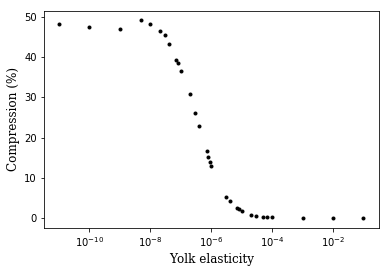

In [22]:
volume_dataframe = pd.DataFrame.from_csv('resultats_yolk.csv')
fig = plt.figure()
ax = fig.add_subplot(111)
volume_dataframe = volume_dataframe.drop(volume_dataframe[volume_dataframe.elasticity == 0].index)
ax.plot(volume_dataframe.index, (1-volume_dataframe.elasticity)*100, '.', color = 'black')

#ax.plot(3.e-6, (1-volume_dataframe.loc[3.e-6, 'elasticity'])*100, 'o',color = 'red')
#ax.axvline(x=3.e-6,ymin=0, ymax=0.08, linewidth=1,linestyle='--', color='red')
#ax.axhline(y=(1-volume_dataframe.loc[3.e-6, 'elasticity'])*100, xmin=0, xmax=0.55,
#           linewidth=1,linestyle='--', color='red')


ax.set_xscale("log")
ax.set_xlabel('Yolk elasticity', size=12, family='serif')
ax.set_ylabel('Compression (%)', size=12, family='serif')


plt.savefig('yolkElasticity.svg', dpi = 300, transparent=True)
plt.savefig("yolkElasticity.pdf", dpi = 300, transparent=True)


In [14]:
volume_dataframe

,compression,elasticity
1.000000e-11,51.699142,0.516991
1.000000e-10,52.540983,0.525410
1.000000e-09,53.029797,0.530298
5.000000e-09,50.902521,0.509025
1.000000e-08,51.893923,0.518939
2.000000e-08,53.607112,0.536071
3.000000e-08,54.577510,0.545775
4.000000e-08,56.724537,0.567245
7.000000e-08,60.737311,0.607373
8.000000e-08,61.397206,0.613972


In [7]:
sheet.settings

{'geometry': 'cylindrical',
 'height_axis': 'z',
 'lumen_prefered_vol': 1655117.8783696312,
 'lumen_vol': 855681.7453258925,
 'lumen_vol_elasticity': 1e-11,
 'nrj_norm_factor': 784,
 'threshold_length': 0.1}

In [15]:
volume_dataframe.to_csv('resultats_yolk.csv')